# 高斯模糊
一维高斯函数
$$
G(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$
二维高斯函数
$$
G(r) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{(r - \mu)^2}{2\sigma^2}\right)
$$
其中
$$
r = \sqrt{x^2 + y^2}
$$
依据中心点，得到
$$
G(x, y) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{(x - \frac{m}{2})^2 + (y - \frac{n}{2})^2}{2\sigma^2}\right)
$$
计作
$$
\Large G(x, y, \sigma)
$$
# 特点
- 拆分
对于其他函数而言，$X$和$Y$的变换是同时的，但是高斯函数可以先变换然后相加即可，拆分了即时算力门槛。
- 叠加
针对一个$\sigma$的变化，可以通过每次比较小的$\sigma_i$重复进行高斯变换，得到的结果一致。


# 高斯差分字塔
- `M`: 图像X
- `N`: 图像Y
- `O`: 组数
- `S`: 层数
$$
S = log_2\left(min(M, N)\right) - 3
$$

针对每一层采用的$\sigma$
$$
\Large \sigma = \sigma_0k^{o + s / S} \quad o \in O, s \in s 
$$

相同组之间$\sigma$之间的取值比例为
$$
\Large \eta_o = \frac{\sigma_0k^{o + (s + 1) / s}}{\sigma_0k^{o + s / S}} = k^{{1}/{S}}
$$

相同层之间的$\sigma$比例为
$$
\Large \eta_s = \frac{\sigma_0k^{(o + 1) + s / S}}{\sigma_0k^{o + s / S}} = k
$$
其中
$$
\Large\sigma_0 = \sqrt{\sigma_{init}^2 - \sigma^2_{pre}}
$$

- $\Large\sigma_{init}$: 第$0$层的尺度，一般为$1.6$
- $\Large\sigma_{pre}$: 被相机模糊后的尺度, 一般为$0.5$

$$
\Large\sigma_0 = \sqrt{\sigma_{init}^2 - \sigma^2_{pre}} = \sqrt{1.6^2 - 0.5^2} = 1.52
$$

也就是图像一开始就丢失了高频信息，所以推荐先把图像放大一倍，算作$-1$层
$$
\Large\sigma_0 = \sqrt{\sigma_{init}^2 - \sigma^2_{pre}} = \sqrt{1.6^2 - (2 \times 0.5) ^2} = 1.25
$$

## 分组
每组之间的尺寸，缩小为原来的一般，也就是
$$
\begin{aligned}
\left\{
\begin{matrix}
x \Rightarrow \frac{x}{2} \\
y \Rightarrow \frac{y}{2} \\
\end{matrix}
\right.
\end{aligned}
$$
一般来说，采取去掉奇/偶行的操作进行缩小。

## 分层
在相同层的图像，尺寸都是相同的，区别在于高斯函数的区别。<br>
$$
\sigma = \sigma_0k^{o + s / S}
$$
把每层的图像和高斯函数卷积的结果计作
$$
L(x, y, \sigma) = G(x, y, \sigma) \bigotimes I(x, y)
$$

# 尺度不变
$LoG(Laplacion of Gaussian)$才具有真正的尺度不变性
$$
\begin{aligned}
LoG = &\sigma^2 \triangledown^2G \\
\approx & \frac{G(x, y, k\sigma) - G(x, y, \sigma)}{\sigma^2(k - 1)}\\
\therefore DoG =& G(x, y, k\sigma) - G(x, y, \sigma)\\ 
\approx&(k-1)\sigma^2\triangledown^2G\\  =& (k - 1)LoG
\end{aligned} 
$$

高斯差分金字塔中，就是使用$DoG$进行尺度的提取。
$$
\begin{aligned}
D(x, y, \sigma) =& \left[ G(x, y, k\sigma) - G(x, y, \sigma)\right] \bigotimes I(x, y) \\ 
=& L(x, y, k\sigma) - L(x, y, \sigma)
\end{aligned}
$$

- 差分


每组之间直接做差，得到计算式。
![](sub.png)

可以看到，其中丢失了一张图片信息。
- 特征


对比上下两张图，一共
$$
8 + 2 \times 9 = 26
$$
个点
![](compare.png)

由于每次都是需要在中间进行操作，丢失了上下两张图片信息。
为了得到$S$张图片，实际在每一层的高斯金字塔中，我们总共需要准备$S+3$张图片

# 为什么上一组第一层是下一组倒数第三张的采样

$$
\begin{aligned}
\Large\sigma_{(o + 1, s = 1)}  
=& \Large\sigma_0k^{(o + 1) + 1/S} \\
=&  \Large\sigma_0k^{o + (S +1) / S} \\
=&  \Large\sigma_0k^{o + (S +3 - 2) / S} \\
=& \Large\sigma_{(o, s = -3)}
\end{aligned}
$$

两者的高斯变换一致，直接采样即可。


# 关键点计算

$$
\Large D(x) = D + \frac{\partial D^T}{\partial X}X + \frac{1}{2}X^T\frac{\partial^2 D}{\partial X^2}X
$$
极值点求解为
$$
\Large D(\hat X) = D + \frac{1}{2}\frac{\partial D^T}{\partial X}X
$$

# 去除边缘效应

边缘对改函数有较大的响应，应该过滤一部分边缘响应，消除边缘影响

$$
H(x, y) = \left[
\begin{aligned}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{aligned}
\right]
$$
同前面的办法一样，可以化为
$$
\left[
\begin{matrix}
\lambda_1 & 0 \\
0 & \lambda_2
\end{matrix}
\right]
\quad \left\{\begin{matrix}
\lambda_1 =& Det(H) =& \lambda_1 + \lambda_2 \\
\lambda_2 =& Tr(H) =& \lambda_1 \lambda_2
\end{matrix}
\right.
$$
假设$\lambda_1 = \gamma \lambda_2$
最小特征值和最大特征值之间的比例为
$$
\frac{Tr(H)^2}{Det(H)} = \frac{\lambda_1 +\lambda_2}{\lambda_1 \lambda_2} = \frac{(\gamma + 1)^2}{\gamma}
$$
对阈值进行过滤，则
$$
\frac{Tr(H)^2}{Det(H)} \le \frac{(\gamma + 1)^2}{\gamma}
$$

大佬$Lowe$论文中推荐$\gamma=10$，也就是主曲率大于$10$将被过滤。

# 像素大小和方向

$$
\begin{aligned}
幅度&: m(x, y) = \sqrt{\left(L(x+1, y) - L(x-1, y)\right)^2 + \left(L(x, y+1) - L(x, y-1)\right)^2} \\
方向&: \theta(x,y) = \tan^-1\left[\frac{L(x, y+1) - L(x, y-1)}{L(x+1, y) - L(x-1, y)}\right]
\end{aligned}
$$

# 方向统计分配
- 选取一定范围
- 对360度进行加权采样
- 每36为一个柱，绘制共10个直方柱图
- 为了鲁棒，最大值为主方向，$80\%$为辅方向，仅保留两个方向


# 方向描述
具体的点特征抽取以后，为了获取旋转不变性，应该对全部方向进行整合描述。

一般对一个特征点取四周四个区域，每个区域确定八个方向上的方向响亮，以此作为特征点的描述。<br>
实践中，以$4 \times 4 \times 8$的描述子效果最佳，也就是一个$128$维的描述子。

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def image_show(image, model=None, location=None, gray=False, show=False):
    if model is not None:
        image = cv2.cvtColor(image, model)
    if location is not None:
        plt.subplot(location)
    cmap = 'gray' if gray else None
    plt.imshow(image, cmap=cmap)
    if show or location is None:
        plt.show()
        

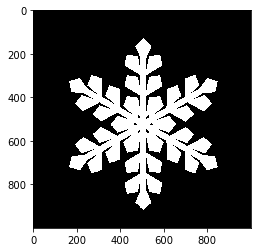

In [3]:
sift_bgr = cv2.imread('snow.png')
sift_gray = cv2.cvtColor(sift_bgr, cv2.COLOR_BGR2GRAY)
image_show(sift_gray, gray=True)

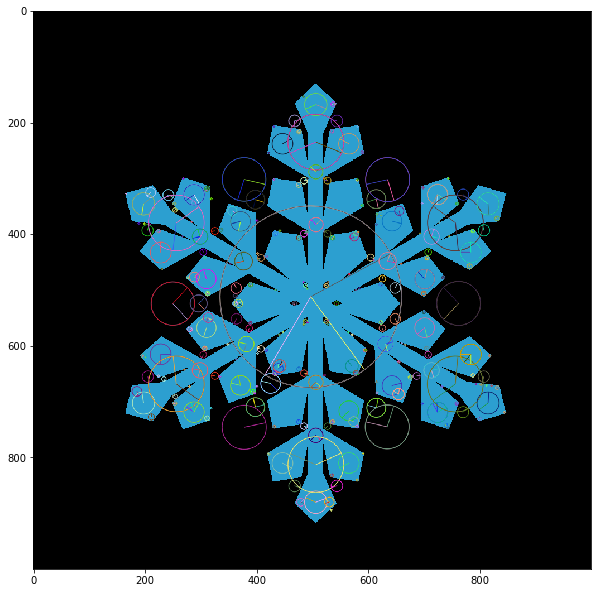

In [4]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints, descriptor = sift.detectAndCompute(sift_gray, None)
plt.figure(figsize=(10,30))
sift_show = cv2.drawKeypoints(sift_bgr, keypoints=keypoints, outImage=sift_bgr, 
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_show(sift_show, model=cv2.COLOR_BGR2RGB)